### Loading data

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Total segment read: 275
(3025, 14)


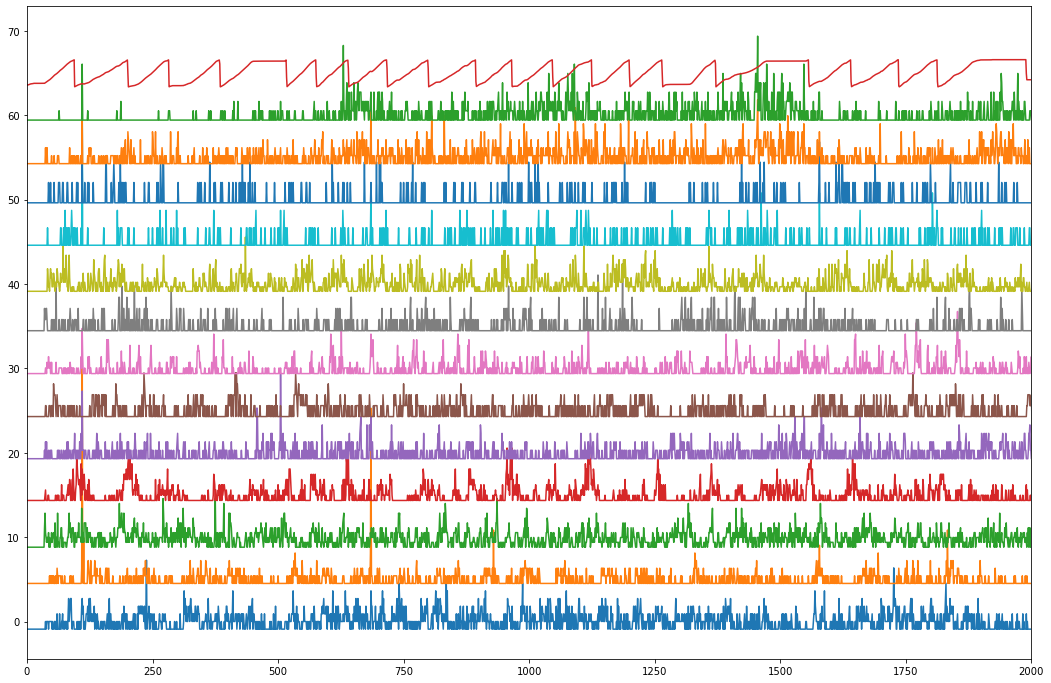

In [1]:
%run 01_load_data.ipynb

### Classification approach

In [2]:
#use a classificaiton approach instead

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

# bin the position into classes
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
bins = np.arange(0,205,10)
pos_binned = np.digitize(pos_scaled,bins)

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train


# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
classifier = svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True)
# classifier.fit(poly_spiketrain,pos_binned)

accu=model_selection.cross_val_score(classifier,poly_spiketrain,pos_binned,cv=5)

print(np.mean(accu))


C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.23104318318647038


C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Text(0.5, 69.0, 'Predicted label')

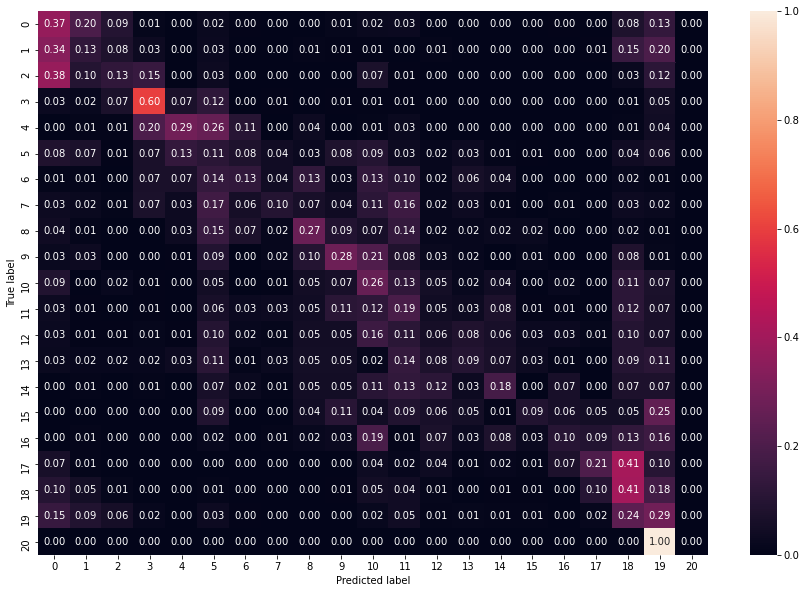

In [3]:
plt.figure(figsize=(15,10))
predicted = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5)
m = metrics.confusion_matrix(pos_binned,predicted,normalize='true') #row is true
ax=sns.heatmap(m,annot=True,fmt='.2f')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

-0.14263225139758728


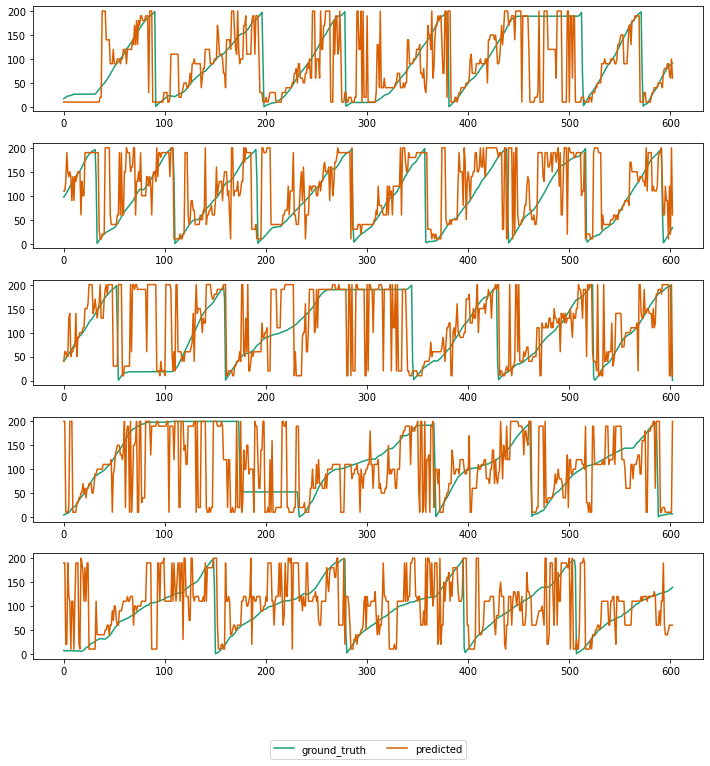

In [4]:
stripplot(pos_scaled,bins[predicted],figsize=(12,12));
varExplain = metrics.explained_variance_score(pos_binned.squeeze(),predicted.ravel())
print(varExplain)

In [5]:
# classification probability
predicted_prob = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5,method='predict_proba')
predicted_pos = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5)

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_validation.py:905: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


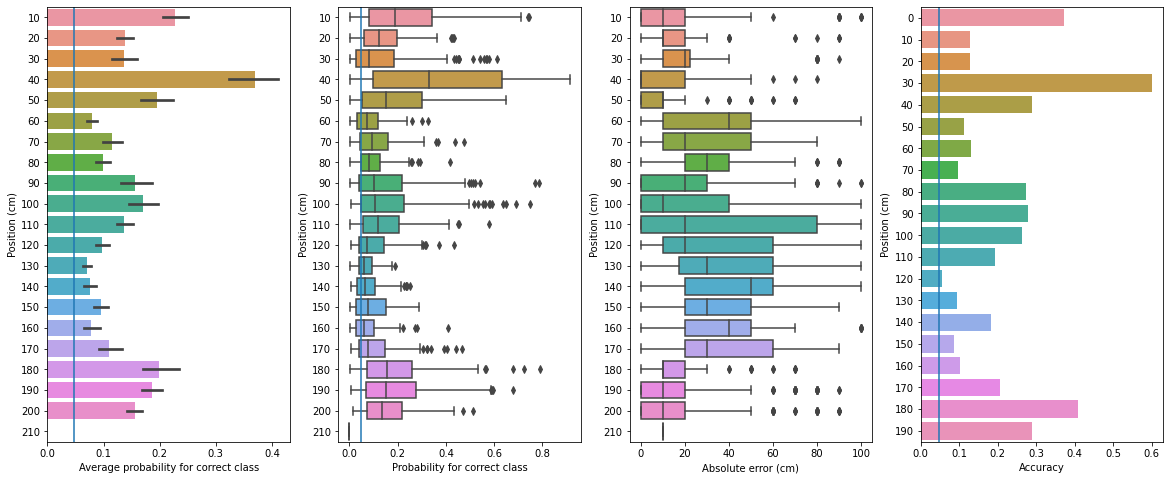

In [6]:
# classification probability vs location

true_class_prob = np.take_along_axis(predicted_prob,(pos_binned-1)[:,None],axis=1)
error = np.abs((predicted_pos-pos_binned))*10
error[error>100] = 200 - error[error>100]
#since 200 and 0 are next to each other, so we change the position to an angle
# plot the firing rate in a circle

df_class = pd.DataFrame({'prob':true_class_prob.ravel(), 'pos':(pos_binned)*10, 'error': error})

fig,ax = plt.subplots(1,4,figsize=(20,8))
axIdx = 0
sns.barplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Average probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

# fig,ax = plt.subplots(1,1,figsize=(10,8))
axIdx += 1
sns.boxplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

axIdx += 1
sns.boxplot(x='error',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Absolute error (cm)')
ax[axIdx].set_ylabel('Position (cm)');



# accuracy for each position
axIdx +=1
accuracy = []
for i in range(predicted_prob.shape[1]-1):
    idx = (pos_binned==i+1) #pos_binned is from 1 to 21
    accuracy.append(np.mean(pos_binned[idx] == predicted_pos[idx]))

sns.barplot(y=np.arange(0,200,10),x=accuracy,orient='h',ax=ax[axIdx])
ax[axIdx].set_xlabel('Accuracy')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])


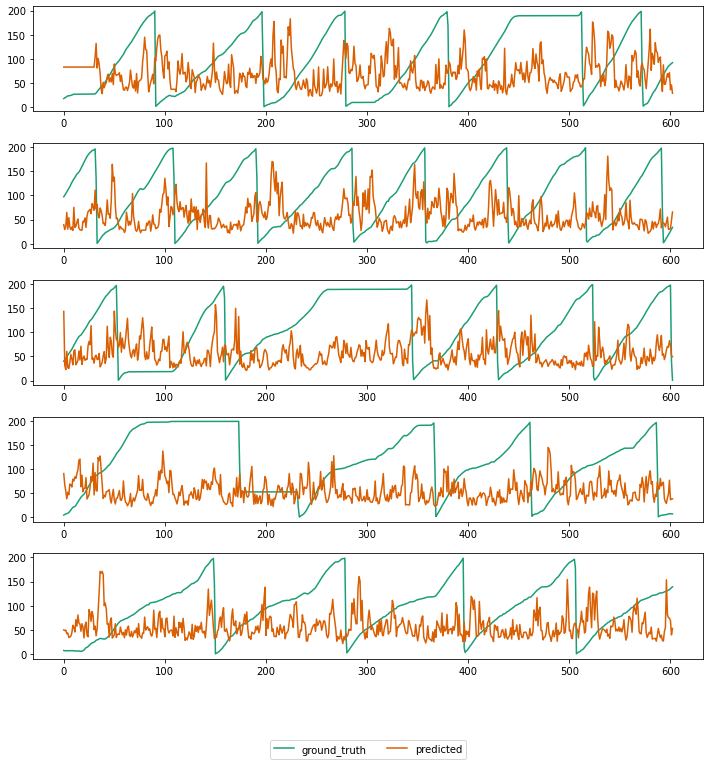

In [7]:
stripplot(pos_scaled,np.max(predicted_prob,axis=1)*200,figsize=(12,12));
